# A Machine Learning Approach for conflicating variant classification 

# Data Exploration and Preprocessing:
    1.Describe the dataset and its features.
    2.Perform data cleaning tasks, including handling missing values, outliers, and inconsistencies.
    3.Conduct exploratory data analysis (EDA) to gain insights into the dataset's characteristics, distributions, and                 relationships.
     3.Visualize the data using appropriate plots and charts to aid in understanding the dataset.

!pip install xgboost

In [ ]:
#Importing neccesary libaries
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [4]:
#loading data set
df= pd.read_csv('clinvar_conflicting.csv')
pd.options.display.max_columns = None

#Descrption of dataset cloumns
df.info()# provide a description Ifno about records ,number of features ,datatype of columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

C:\Users\Dell\AppData\Local\Temp\ipykernel_14980\3386139706.py:2: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('clinvar_conflicting.csv')


# inference 
so removing the nulls will from all data set will not be applicable 

In [114]:
df.head()

CHROM      POS REF ALT  AF_ESP  AF_EXAC  AF_TGP  \
0     1  1168180   G   C  0.0771  0.10020  0.1066   
1     1  1470752   G   A  0.0000  0.00000  0.0000   
2     1  1737942   A   G  0.0000  0.00001  0.0000   
3     1  2160305   G   A  0.0000  0.00000  0.0000   
4     1  2160305   G   T  0.0000  0.00000  0.0000   

                                               CLNDN  \
0                                      not_specified   
1             Spinocerebellar_ataxia_21|not_provided   
2  Strabismus|Nystagmus|Hypothyroidism|Intellectu...   
3          Shprintzen-Goldberg_syndrome|not_provided   
4                       Shprintzen-Goldberg_syndrome   

                     CLNHGVS                      CLNVC  ORIGIN  CLASS Allele  \
0  NC_000001.10:g.1168180G>C  single_nucleotide_variant       1      0      C   
1  NC_000001.10:g.1470752G>A  single_nucleotide_variant       1      0      A   
2  NC_000001.10:g.1737942A>G  single_nucleotide_variant      35      1      G   
3  NC_000001.10:g.2160305G>A  single_nucleotide_variant      33      0      A   
4  NC_000001.10:g.2160305G>T  single_nucleotide_variant      33      0      T   

        Consequence    IMPACT   SYMBOL Feature_type         BIOTYPE  \
0  missense_variant  MODERATE  B3GALT6   Transcript  protein_coding   
1  missense_variant  MODERATE  TMEM240   Transcript  protein_coding   
2  missense_variant  MODERATE     GNB1   Transcript  protein_coding   
3  missense_variant  MODERATE      SKI   Transcript  protein_coding   
4  missense_variant  MODERATE      SKI   Transcript  protein_coding   

  cDNA_position CDS_position Protein_position Amino_acids   Codons  STRAND  \
0           552          522              174         E/D  gaG/gaC     1.0   
1           523          509              170         P/L  cCg/cTg    -1.0   
2           632          239               80         I/T  aTc/aCc    -1.0   
3           132          100               34         G/S  Ggc/Agc     1.0   
4           132          100               34         G/C  Ggc/Tgc     1.0   

   LoFtool  CADD_PHRED  
0      NaN       1.053  
1      NaN      31.000  
2      NaN      28.100  
3      NaN      22.500  
4      NaN      24.700

In [115]:
df.shape

(65188, 26)

# Handling Duplicates and missing values

In [7]:
#chekng no.of duplicates

df.duplicated().sum()

0

In [8]:
#remoing duplicates
df.drop_duplicates(keep = False, inplace = True)
print ('number of duplicates after applying duplicates removing',df.duplicated().sum())

number of duplicates after applying duplicates removing 0


# we craeted a new dataset that contain the variabes name ,data type , the precentage of nulls  and the precentage of uniqzue values

In [9]:
# create new dataframe with data type, nulls, & unique values
var_df = pd.DataFrame(columns=['variable_name', 'data_type', 'missing_percentage', 'flag', 'unique_values_count'])

missing_percentages = df.isnull().mean() * 100
missing_percentages = missing_percentages.sort_values(ascending=False)

# create variables and flag as numeric or categorial
for col in df.columns:
    data_type = df[col].dtype
    missing_percentage = missing_percentages[col]
    unique_values_count = df[col].nunique()
    if data_type == 'int64' or data_type == 'float64':
        flag = 'numeric'
    else:
        flag = 'categorical'


 # concat values obtained into a new dataframe called 'var_df'
    var_df = pd.concat([var_df, pd.DataFrame({'variable_name': [col], 'data_type': [data_type], 'missing_percentage': [missing_percentage], 'flag': [flag], 'unique_values_count': [unique_values_count]})], ignore_index=True)

var_df.info()
print(var_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   variable_name        46 non-null     object 
 1   data_type            46 non-null     object 
 2   missing_percentage   46 non-null     float64
 3   flag                 46 non-null     object 
 4   unique_values_count  46 non-null     object 
dtypes: float64(1), object(4)
memory usage: 1.9+ KB
         variable_name data_type  missing_percentage         flag  \
0                CHROM    object            0.000000  categorical   
1                  POS     int64            0.000000      numeric   
2                  REF    object            0.000000  categorical   
3                  ALT    object            0.000000  categorical   
4               AF_ESP   float64            0.000000      numeric   
5              AF_EXAC   float64            0.000000      numeric   
6            

In [10]:
# sort variables by missing percentage value
var_df_sorted = var_df.sort_values(by='missing_percentage')
var_df_sorted.reset_index(drop=True, inplace=True)

var_df_sorted

variable_name data_type  missing_percentage         flag  \
0                CHROM    object            0.000000  categorical   
1          Consequence    object            0.000000  categorical   
2               ORIGIN     int64            0.000000      numeric   
3               IMPACT    object            0.000000  categorical   
4                CLNVC    object            0.000000  categorical   
5              CLNHGVS    object            0.000000  categorical   
6                CLASS     int64            0.000000      numeric   
7                CLNDN    object            0.000000  categorical   
8               AF_TGP   float64            0.000000      numeric   
9              AF_EXAC   float64            0.000000      numeric   
10              AF_ESP   float64            0.000000      numeric   
11                 ALT    object            0.000000  categorical   
12                 REF    object            0.000000  categorical   
13                 POS     int64            0.000000      numeric   
14            CLNDISDB    object            0.000000  categorical   
15              Allele    object            0.000000  categorical   
16              STRAND   float64            0.021476      numeric   
17             Feature    object            0.021476  categorical   
18        Feature_type    object            0.021476  categorical   
19             BIOTYPE    object            0.024544  categorical   
20              SYMBOL    object            0.024544  categorical   
21                  MC    object            1.297785  categorical   
22            CADD_RAW   float64            1.675155      numeric   
23          CADD_PHRED   float64            1.675155      numeric   
24             LoFtool   float64            6.462846      numeric   
25       cDNA_position    object           13.628275  categorical   
26                EXON    object           13.642081  categorical   
27        CDS_position    object           15.271216  categorical   
28    Protein_position    object           15.271216  categorical   
29         Amino_acids    object           15.346383  categorical   
30              Codons    object           15.346383  categorical   
31            BAM_EDIT    object           50.958765  categorical   
32               CLNVI    object           57.570412  categorical   
33            BLOSUM62   float64           60.739707      numeric   
34                SIFT    object           61.900963  categorical   
35            PolyPhen    object           61.962324  categorical   
36              INTRON    object           86.495981  categorical   
37        CLNDISDBINCL    object           99.743818  categorical   
38           CLNDNINCL    object           99.743818  categorical   
39          CLNSIGINCL    object           99.743818  categorical   
40                 SSR   float64           99.800577      numeric   
41            DISTANCE   float64           99.834325      numeric   
42          MOTIF_NAME    object           99.996932  categorical   
43           MOTIF_POS   float64           99.996932      numeric   
44        HIGH_INF_POS    object           99.996932  categorical   
45  MOTIF_SCORE_CHANGE   float64           99.996932      numeric   

   unique_values_count  
0                   38  
1                   48  
2                   31  
3                    4  
4                    7  
5                65188  
6                    2  
7                 9260  
8                 2087  
9                 6667  
10                2842  
11                 458  
12                 866  
13               63115  
14                9234  
15                 374  
16                   2  
17                2369  
18                   2  
19                   2  
20                2328  
21                  90  
22               63803  
23                9324  
24                1195  
25               13970  
26                3264  
27               13663  
28                7339  
29             

# inference :
        From this we found that we have a columns that have percentage of nulls greater than 40% precent so we talked decision  to remove it 

In [11]:
var_df = var_df_sorted.copy()

# Set the threshold for missing values percentage and drop if necessary
threshold = 50
var_df = var_df[var_df['missing_percentage'] <= threshold]

var_df

variable_name data_type  missing_percentage         flag  \
0              CHROM    object            0.000000  categorical   
1        Consequence    object            0.000000  categorical   
2             ORIGIN     int64            0.000000      numeric   
3             IMPACT    object            0.000000  categorical   
4              CLNVC    object            0.000000  categorical   
5            CLNHGVS    object            0.000000  categorical   
6              CLASS     int64            0.000000      numeric   
7              CLNDN    object            0.000000  categorical   
8             AF_TGP   float64            0.000000      numeric   
9            AF_EXAC   float64            0.000000      numeric   
10            AF_ESP   float64            0.000000      numeric   
11               ALT    object            0.000000  categorical   
12               REF    object            0.000000  categorical   
13               POS     int64            0.000000      numeric   
14          CLNDISDB    object            0.000000  categorical   
15            Allele    object            0.000000  categorical   
16            STRAND   float64            0.021476      numeric   
17           Feature    object            0.021476  categorical   
18      Feature_type    object            0.021476  categorical   
19           BIOTYPE    object            0.024544  categorical   
20            SYMBOL    object            0.024544  categorical   
21                MC    object            1.297785  categorical   
22          CADD_RAW   float64            1.675155      numeric   
23        CADD_PHRED   float64            1.675155      numeric   
24           LoFtool   float64            6.462846      numeric   
25     cDNA_position    object           13.628275  categorical   
26              EXON    object           13.642081  categorical   
27      CDS_position    object           15.271216  categorical   
28  Protein_position    object           15.271216  categorical   
29       Amino_acids    object           15.346383  categorical   
30            Codons    object           15.346383  categorical   

   unique_values_count  
0                   38  
1                   48  
2                   31  
3                    4  
4                    7  
5                65188  
6                    2  
7                 9260  
8                 2087  
9                 6667  
10                2842  
11                 458  
12                 866  
13               63115  
14                9234  
15                 374  
16                   2  
17                2369  
18                   2  
19                   2  
20                2328  
21                  90  
22               63803  
23                9324  
24                1195  
25               13970  
26                3264  
27               13663  
28                7339  
29                1262  
30                2220

In [12]:
# on the original data set
threshold = 50

missing_percentages = df.isnull().mean() * 100
columns_to_drop = missing_percentages[missing_percentages > threshold].index.tolist()

df = df.drop(columns=columns_to_drop)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDISDB          65188 non-null  object 
 8   CLNDN             65188 non-null  object 
 9   CLNHGVS           65188 non-null  object 
 10  CLNVC             65188 non-null  object 
 11  MC                64342 non-null  object 
 12  ORIGIN            65188 non-null  int64  
 13  CLASS             65188 non-null  int64  
 14  Allele            65188 non-null  object 
 15  Consequence       65188 non-null  object 
 16  IMPACT            65188 non-null  object

In [13]:
numerical_columns = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_columns.corr() # calculate correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

#### EXON = contains dates, not performing time series, not relevant, CLNDISB = Provides MedGen database identifiers, not relevant, Feature: Value included in consequence column, MC ‘identifier; 'CADD_RAW:  directly related to CADD_PHRED - only CADD_PHRED is needed with respect to genetic mutations, it uses a scale that is easier to work with.

In [14]:
df.drop(['EXON', 'CLNDISDB','Feature',
         'MC','CADD_RAW',], axis=1, inplace=True)

In [15]:
numerical_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   POS         65188 non-null  int64  
 1   AF_ESP      65188 non-null  float64
 2   AF_EXAC     65188 non-null  float64
 3   AF_TGP      65188 non-null  float64
 4   ORIGIN      65188 non-null  int64  
 5   CLASS       65188 non-null  int64  
 6   STRAND      65174 non-null  float64
 7   LoFtool     60975 non-null  float64
 8   CADD_PHRED  64096 non-null  float64
 9   CADD_RAW    64096 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 5.0 MB


In [16]:
object_cols = df.select_dtypes(include=['object'])
object_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CHROM             65188 non-null  object
 1   REF               65188 non-null  object
 2   ALT               65188 non-null  object
 3   CLNDN             65188 non-null  object
 4   CLNHGVS           65188 non-null  object
 5   CLNVC             65188 non-null  object
 6   Allele            65188 non-null  object
 7   Consequence       65188 non-null  object
 8   IMPACT            65188 non-null  object
 9   SYMBOL            65172 non-null  object
 10  Feature_type      65174 non-null  object
 11  BIOTYPE           65172 non-null  object
 12  cDNA_position     56304 non-null  object
 13  CDS_position      55233 non-null  object
 14  Protein_position  55233 non-null  object
 15  Amino_acids       55184 non-null  object
 16  Codons            55184 non-null  object
dtypes: object(17

In [17]:
still_missing = pd.DataFrame()

# Iterate over the columns of the DataFrame and isolate missing columns
for column in df.columns:
    if df[column].isnull().any():
        still_missing[column] = df[column]

print("Columns with missing values:")
still_missing.info()

Columns with missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SYMBOL            65172 non-null  object 
 1   Feature_type      65174 non-null  object 
 2   BIOTYPE           65172 non-null  object 
 3   cDNA_position     56304 non-null  object 
 4   CDS_position      55233 non-null  object 
 5   Protein_position  55233 non-null  object 
 6   Amino_acids       55184 non-null  object 
 7   Codons            55184 non-null  object 
 8   STRAND            65174 non-null  float64
 9   LoFtool           60975 non-null  float64
 10  CADD_PHRED        64096 non-null  float64
dtypes: float64(3), object(8)
memory usage: 5.5+ MB


In [120]:
# Loop through each column in the still_missing DataFrame
for column in still_missing.columns:
    if still_missing[column].dtype == 'object':
        # Fill missing values in object columns with forward fill (ffill)
        still_missing[column] = still_missing[column].fillna(method='ffill')
    elif still_missing[column].dtype == 'float64':
        # Interpolate missing values in float64 columns
        still_missing[column] = still_missing[column].interpolate()

# Calculate the mean of the 'LoFtool' column
try:
    loftool_mean = still_missing['LoFtool'].fillna(method='ffill')
  # Rest of your code using loftool_mean
except KeyError:
    print("'LoFtool' column not found. Skipping mean calculation.")
  # Handle the case where the column is missing
# Check the updated DataFrame information
still_missing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SYMBOL            65188 non-null  object 
 1   Feature_type      65188 non-null  object 
 2   BIOTYPE           65188 non-null  object 
 3   cDNA_position     65188 non-null  object 
 4   CDS_position      65188 non-null  object 
 5   Protein_position  65188 non-null  object 
 6   Amino_acids       65188 non-null  object 
 7   Codons            65188 non-null  object 
 8   STRAND            65188 non-null  float64
 9   LoFtool           65182 non-null  float64
 10  CADD_PHRED        65188 non-null  float64
dtypes: float64(3), object(8)
memory usage: 5.5+ MB


In [117]:
df.update(still_missing)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  object 
 8   CLNHGVS           65188 non-null  object 
 9   CLNVC             65188 non-null  object 
 10  ORIGIN            65188 non-null  int64  
 11  CLASS             65188 non-null  int64  
 12  Allele            65188 non-null  object 
 13  Consequence       65188 non-null  object 
 14  IMPACT            65188 non-null  object 
 15  SYMBOL            65188 non-null  object 
 16  Feature_type      65188 non-null  object

In [20]:
#label_encoder = LabelEncoder()

# Loop through each column in the DataFrame
#for column in df.columns:
    # Check if the column's dtype is 'object' or contains mixed types
    #if df[column].dtype == 'object' or df[column].apply(lambda x: isinstance(x, str)).any():
        # Convert all values in the column to string to avoid mixed type issues
        #df[column] = df[column].astype(str)
        # Apply label encoding to the column
        #df[column] = label_encoder.fit_transform(df[column])

#df.info()

In [21]:
for column in df.columns:
    # Check if the column has 'int32' data type
    if df[column].dtype == 'int32':
        # Change 'int32' to 'int64'
        df[column] = df[column].astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  object 
 8   CLNHGVS           65188 non-null  object 
 9   CLNVC             65188 non-null  object 
 10  ORIGIN            65188 non-null  int64  
 11  CLASS             65188 non-null  int64  
 12  Allele            65188 non-null  object 
 13  Consequence       65188 non-null  object 
 14  IMPACT            65188 non-null  object 
 15  SYMBOL            65188 non-null  object 
 16  Feature_type      65188 non-null  object

In [22]:
 #Filter numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns

# Calculate the number of rows and columns for subplots
num_columns = 3
num_rows = (len(numerical_columns) - 1) // num_columns + 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Iterate through numerical columns and plot boxplots
for i, column in enumerate(numerical_columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row][col] if num_rows > 1 else axes[col]  # Adjust if there's only one row
    df.boxplot(column=column, ax=ax)
    ax.set_title(column)

# Remove any empty subplots
for j in range(len(numerical_columns), num_rows * num_columns):
    fig.delaxes(axes.flatten()[j])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

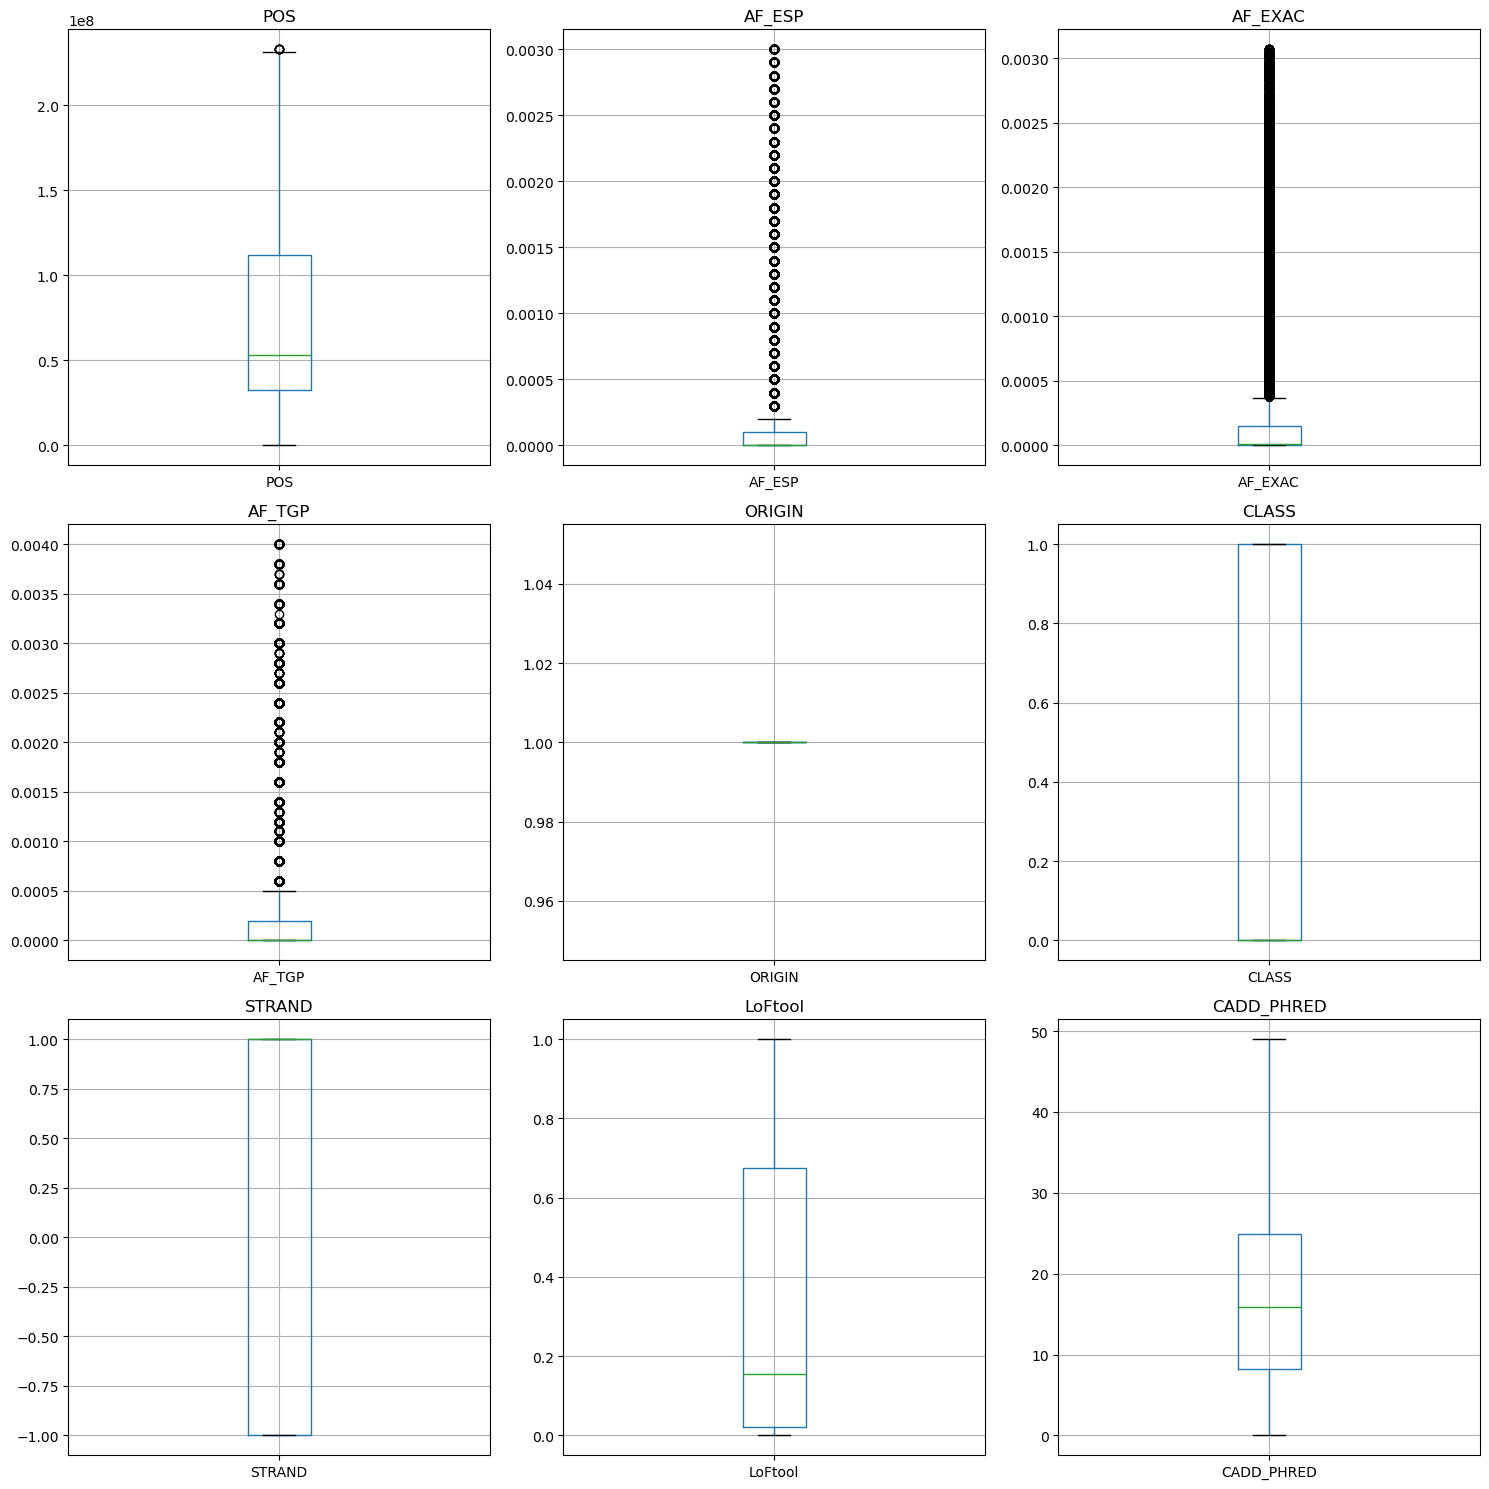

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to remove outliers using IQR
def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Mask for each column to filter out the outliers
    mask = (df >= lower_bound) & (df <= upper_bound)

    # Remove rows with any outliers
    df_cleaned = df[mask.all(axis=1)]

    return df_cleaned

# Filter numerical columns
numerical_columns = df.select_dtypes(include=['number'])

# Remove outliers
df_cleaned = remove_outliers_iqr(numerical_columns)

# Calculate the number of rows and columns for subplots
num_columns = 3
num_rows = (len(df_cleaned.columns) - 1) // num_columns + 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Iterate through columns and plot boxplots
for i, column in enumerate(df_cleaned.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row][col] if num_rows > 1 else axes[col]  # Adjust if there's only one row
    df_cleaned.boxplot(column=column, ax=ax)
    ax.set_title(column)

# Remove any empty subplots
for j in range(len(df_cleaned.columns), num_rows * num_columns):
    fig.delaxes(axes.flatten()[j])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()
    


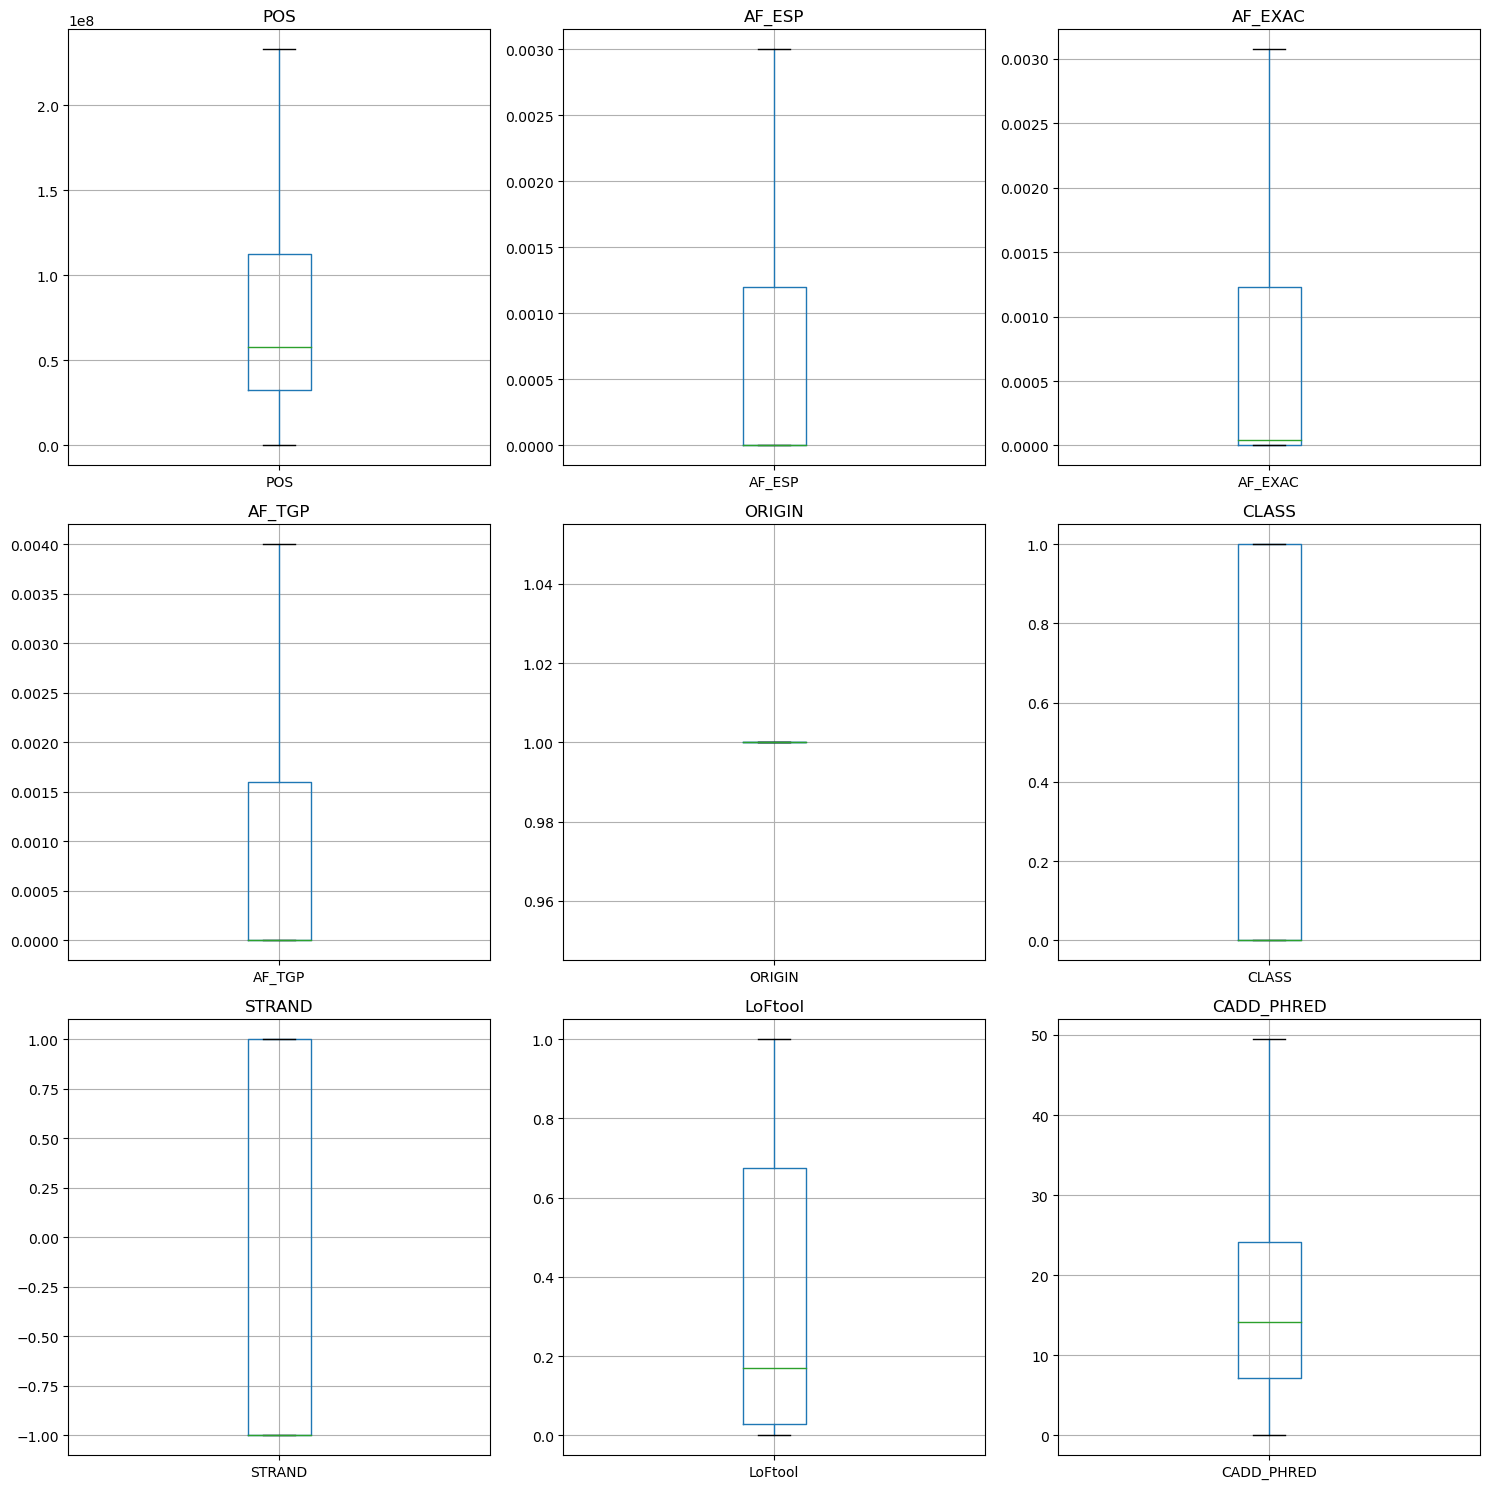

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to cap outliers using IQR
def cap_outliers_iqr(df):
    df_capped = df.copy()
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers for each column
    for column in df.columns:
        df_capped[column] = np.where(df[column] < lower_bound[column], lower_bound[column], df[column])
        df_capped[column] = np.where(df_capped[column] > upper_bound[column], upper_bound[column], df_capped[column])

    return df_capped



# Separate numerical columns
numerical_columns = df.select_dtypes(include=['number'])

# Cap the outliers
df_capped_numerical = cap_outliers_iqr(numerical_columns)

# Fill missing values with the mean of the columns (if there are any missing values)
df_capped_numerical = df_capped_numerical.fillna(df_capped_numerical.mean())

# Update the original DataFrame with capped numerical columns
df_updated = df.copy()
df_updated[numerical_columns.columns] = df_capped_numerical

# Calculate the number of rows and columns for subplots
num_columns = 3
num_rows = (len(numerical_columns.columns) - 1) // num_columns + 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Iterate through columns and plot boxplots
for i, column in enumerate(numerical_columns.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row][col] if num_rows > 1 else axes[col]  # Adjust if there's only one row
    df_updated.boxplot(column=column, ax=ax)
    ax.set_title(column)

# Remove any empty subplots
for j in range(len(numerical_columns.columns), num_rows * num_columns):
    fig.delaxes(axes.flatten()[j])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()





# inference :
    now we have our data cleand with no nulls or outliers 

In [25]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  float64
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  object 
 8   CLNHGVS           65188 non-null  object 
 9   CLNVC             65188 non-null  object 
 10  ORIGIN            65188 non-null  float64
 11  CLASS             65188 non-null  float64
 12  Allele            65188 non-null  object 
 13  Consequence       65188 non-null  object 
 14  IMPACT            65188 non-null  object 
 15  SYMBOL            65188 non-null  object 
 16  Feature_type      65188 non-null  object

In [26]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  float64
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  object 
 8   CLNHGVS           65188 non-null  object 
 9   CLNVC             65188 non-null  object 
 10  ORIGIN            65188 non-null  float64
 11  CLASS             65188 non-null  float64
 12  Allele            65188 non-null  object 
 13  Consequence       65188 non-null  object 
 14  IMPACT            65188 non-null  object 
 15  SYMBOL            65188 non-null  object 
 16  Feature_type      65188 non-null  object

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(x='CHROM', hue='IMPACT', data=df_updated, palette='Set1')
plt.xticks(rotation=90)
plt.title('Count of IMPACT categories for each CHROM')
plt.show()



In [28]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go #for plotly graphs
dtt = df_updated.head(800).assign(n=0).groupby(['POS', 'CADD_PHRED'])['n'].count().reset_index()
dtt = dtt[dtt["CADD_PHRED"] < 2000]
ver = dtt.pivot(index='CADD_PHRED', columns='POS', values='n').fillna(0).values.tolist()
iplot([go.Surface(z=ver)])
#plotly Surface (the most impressive feature)
#shows the distribution of POS against CADD_PHR

In [29]:
!pip install missingno


In [30]:
import missingno as msno
msno.bar(df_updated,color='#79ccb3',sort='descending')
plt.show()

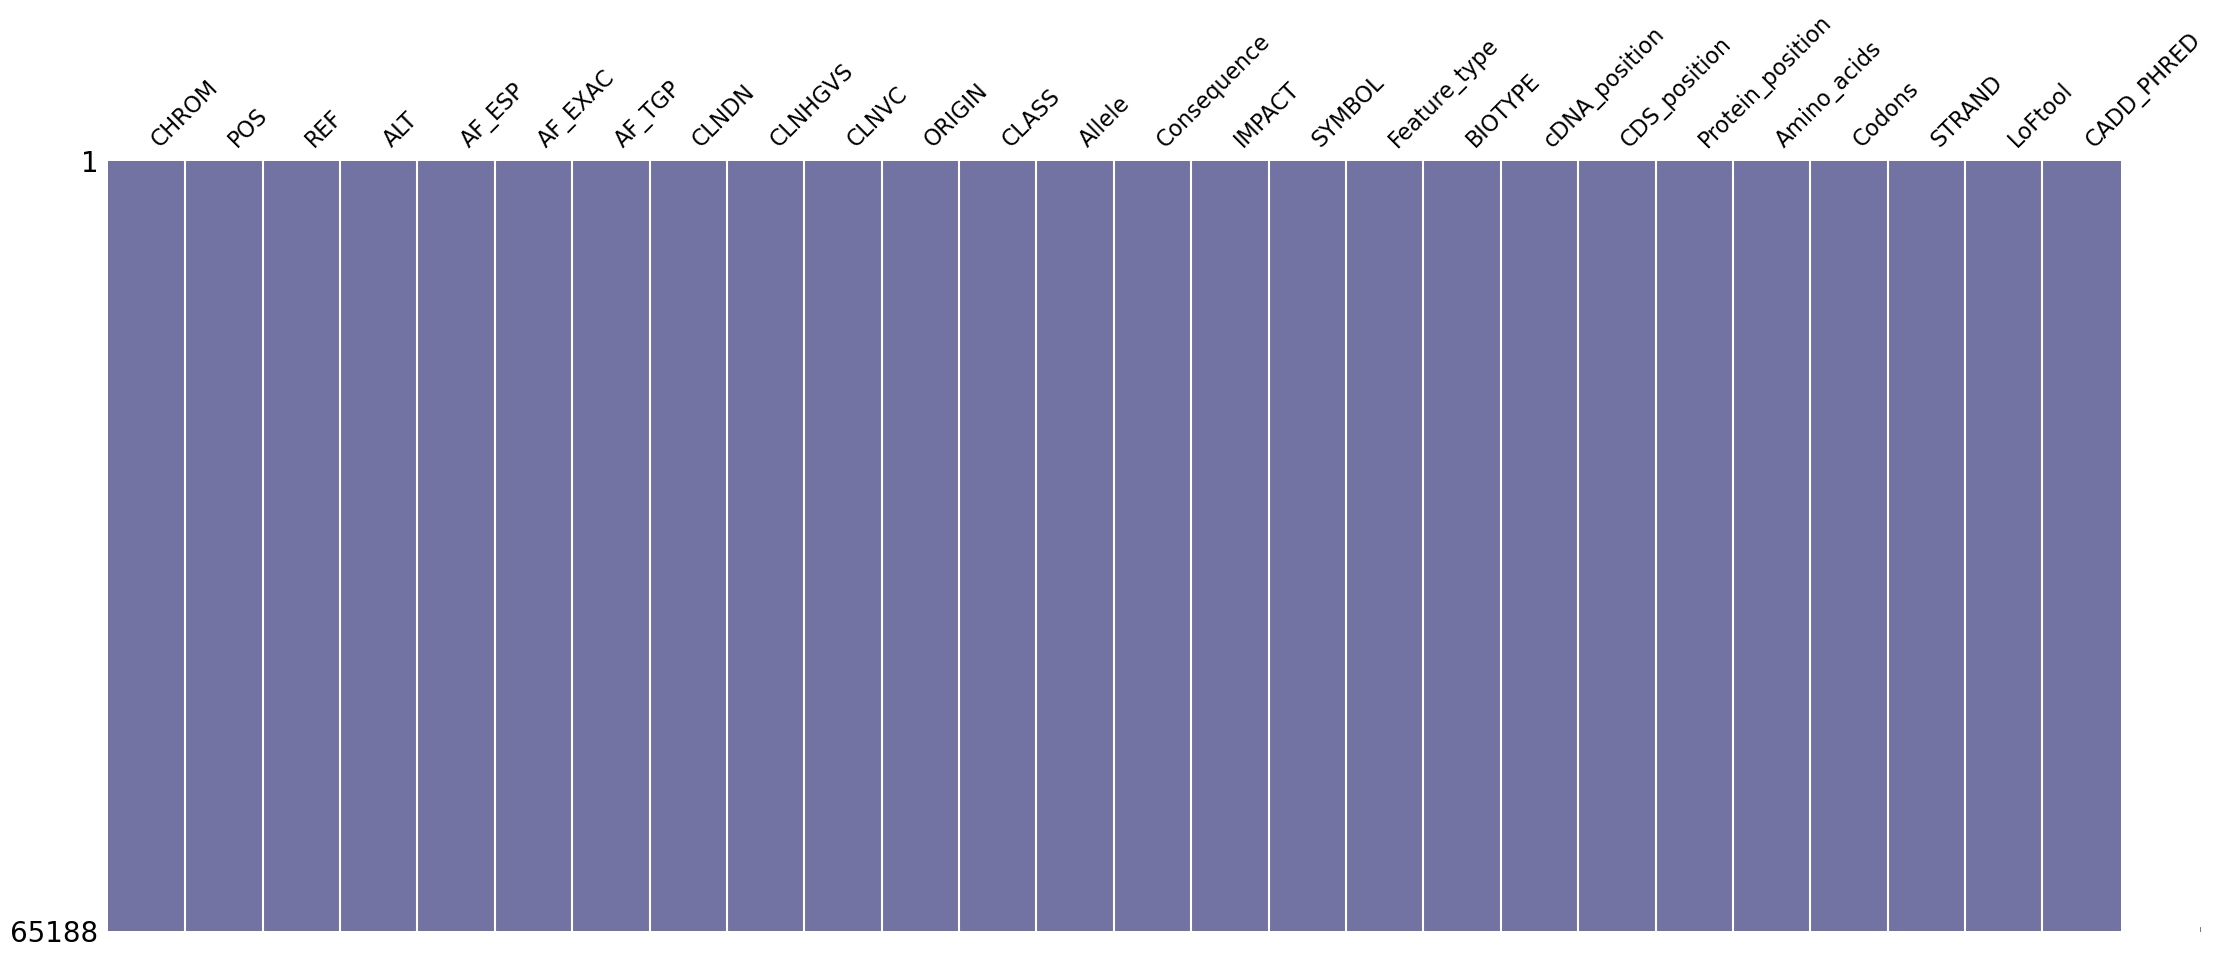

In [31]:
msno.matrix(df_updated,color=(0.45,0.45,0.64),figsize=(27, 10), width_ratios=(10, 0))
plt.show()

### there is no nissiing values

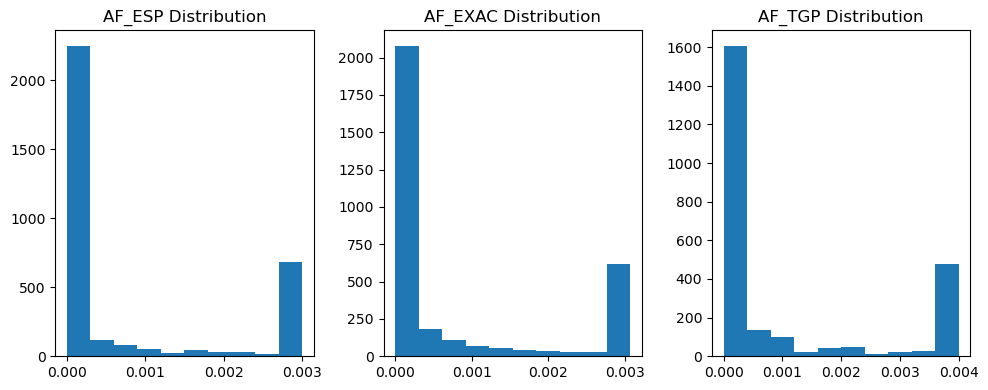

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 4))

# Plot histograms for each column

ax1.hist(df_updated['AF_ESP'], bins=10, density=True)
ax1.set_title('AF_ESP Distribution')


ax2.hist(df_updated['AF_EXAC'], bins=10, density=True)
ax2.set_title('AF_EXAC Distribution')


ax3.hist(df_updated['AF_TGP'], bins=10, density=True)
ax3.set_title('AF_TGP Distribution')

plt.tight_layout()

plt.show()

#### allele  frequency are concentrated in region from 0.00 to 0.004 '

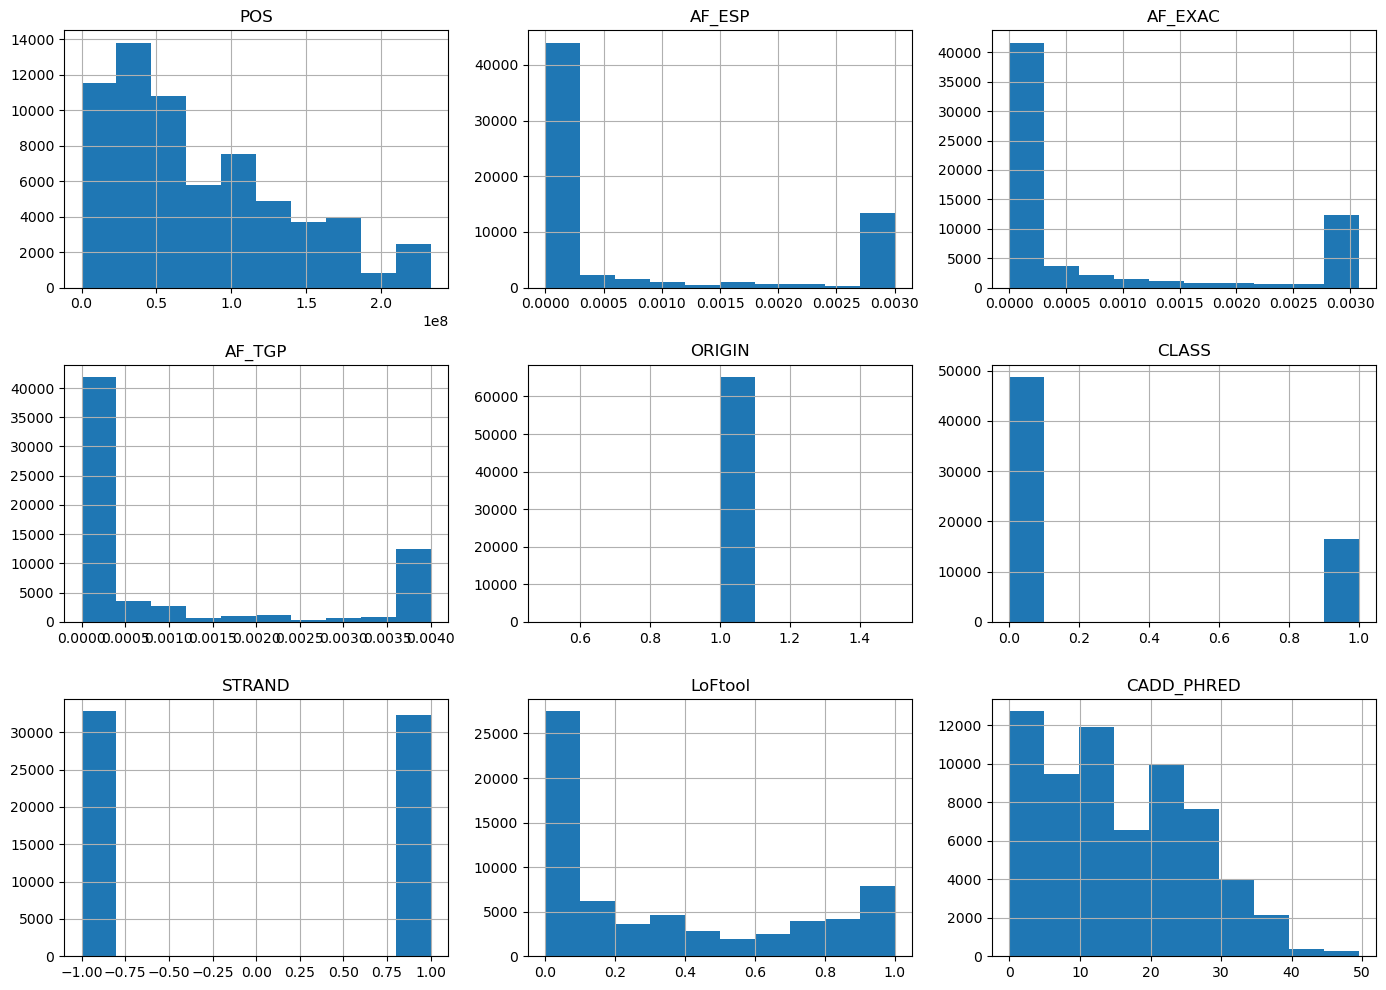

In [33]:
# Plot histograms of all columns with larger size
df_updated.hist(figsize=(14, 10))
plt.tight_layout()
plt.show()

In [34]:
if 'CLASS' in df_updated.columns and 'CHROM' in df_updated.columns:
    # Correcting the countplot with the hue parameter
    ax = sns.countplot(x="CLASS", hue="CHROM", data=df_updated, palette="Set1")
    
    # Setting the labels for the axes
    ax.set(xlabel='CLASS', ylabel='Number of Variants')
    
    # Display the legend
    plt.legend(title='CHROM')
    plt.show()
else:
    print("Columns 'CLASS' and/or 'CHROM' not found in the DataFrame.")

## inference :
    class 0 have higher number of variantz

In [35]:
gene_ct = pd.crosstab(df_updated.SYMBOL, df_updated.CLASS, margins=True)
gene_ct.drop('All', axis=0, inplace=True)

# limit to the 50 most submitted genes for visualization
gene_ct = gene_ct.sort_values(by='All', ascending=False).head(50)
gene_ct.drop('All', axis=1, inplace=True)

gene_ct.plot.bar(stacked=True, figsize=(12, 4))

<Axes: xlabel='SYMBOL'>

# inference :
    we can identify that gene TNN is the most common specially in class 0

In [36]:
snvs = df_updated.loc[(df_updated.REF.str.len()==1) & (df_updated.ALT.str.len()==1)]
indels = df_updated.loc[(df_updated.REF.str.len()>1) | (df_updated.ALT.str.len()>1)]

In [37]:
len(df_updated) == (len(snvs) + len(indels))

True

In [38]:
snp_indel = pd.concat([snvs.CLASS.value_counts(normalize=True).rename('snv_class'), 
                       indels.CLASS.value_counts(normalize=True).rename('indel_class')], 
                      axis=1).T

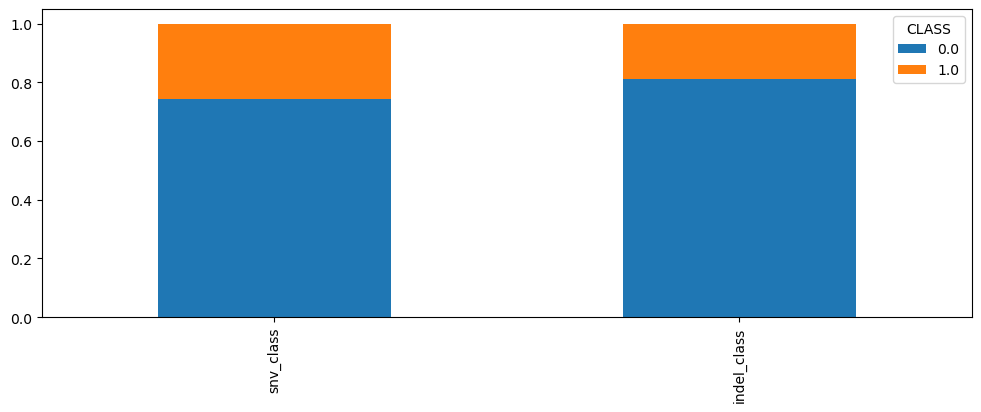

In [39]:
snp_indel.plot.bar(stacked=True, figsize=(12, 4));

# inference  
that indels induced alteration is more frequent in class o while single nucleotide polymorphism is more in class 1 

C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



<Figure size 1000x600 with 0 Axes>

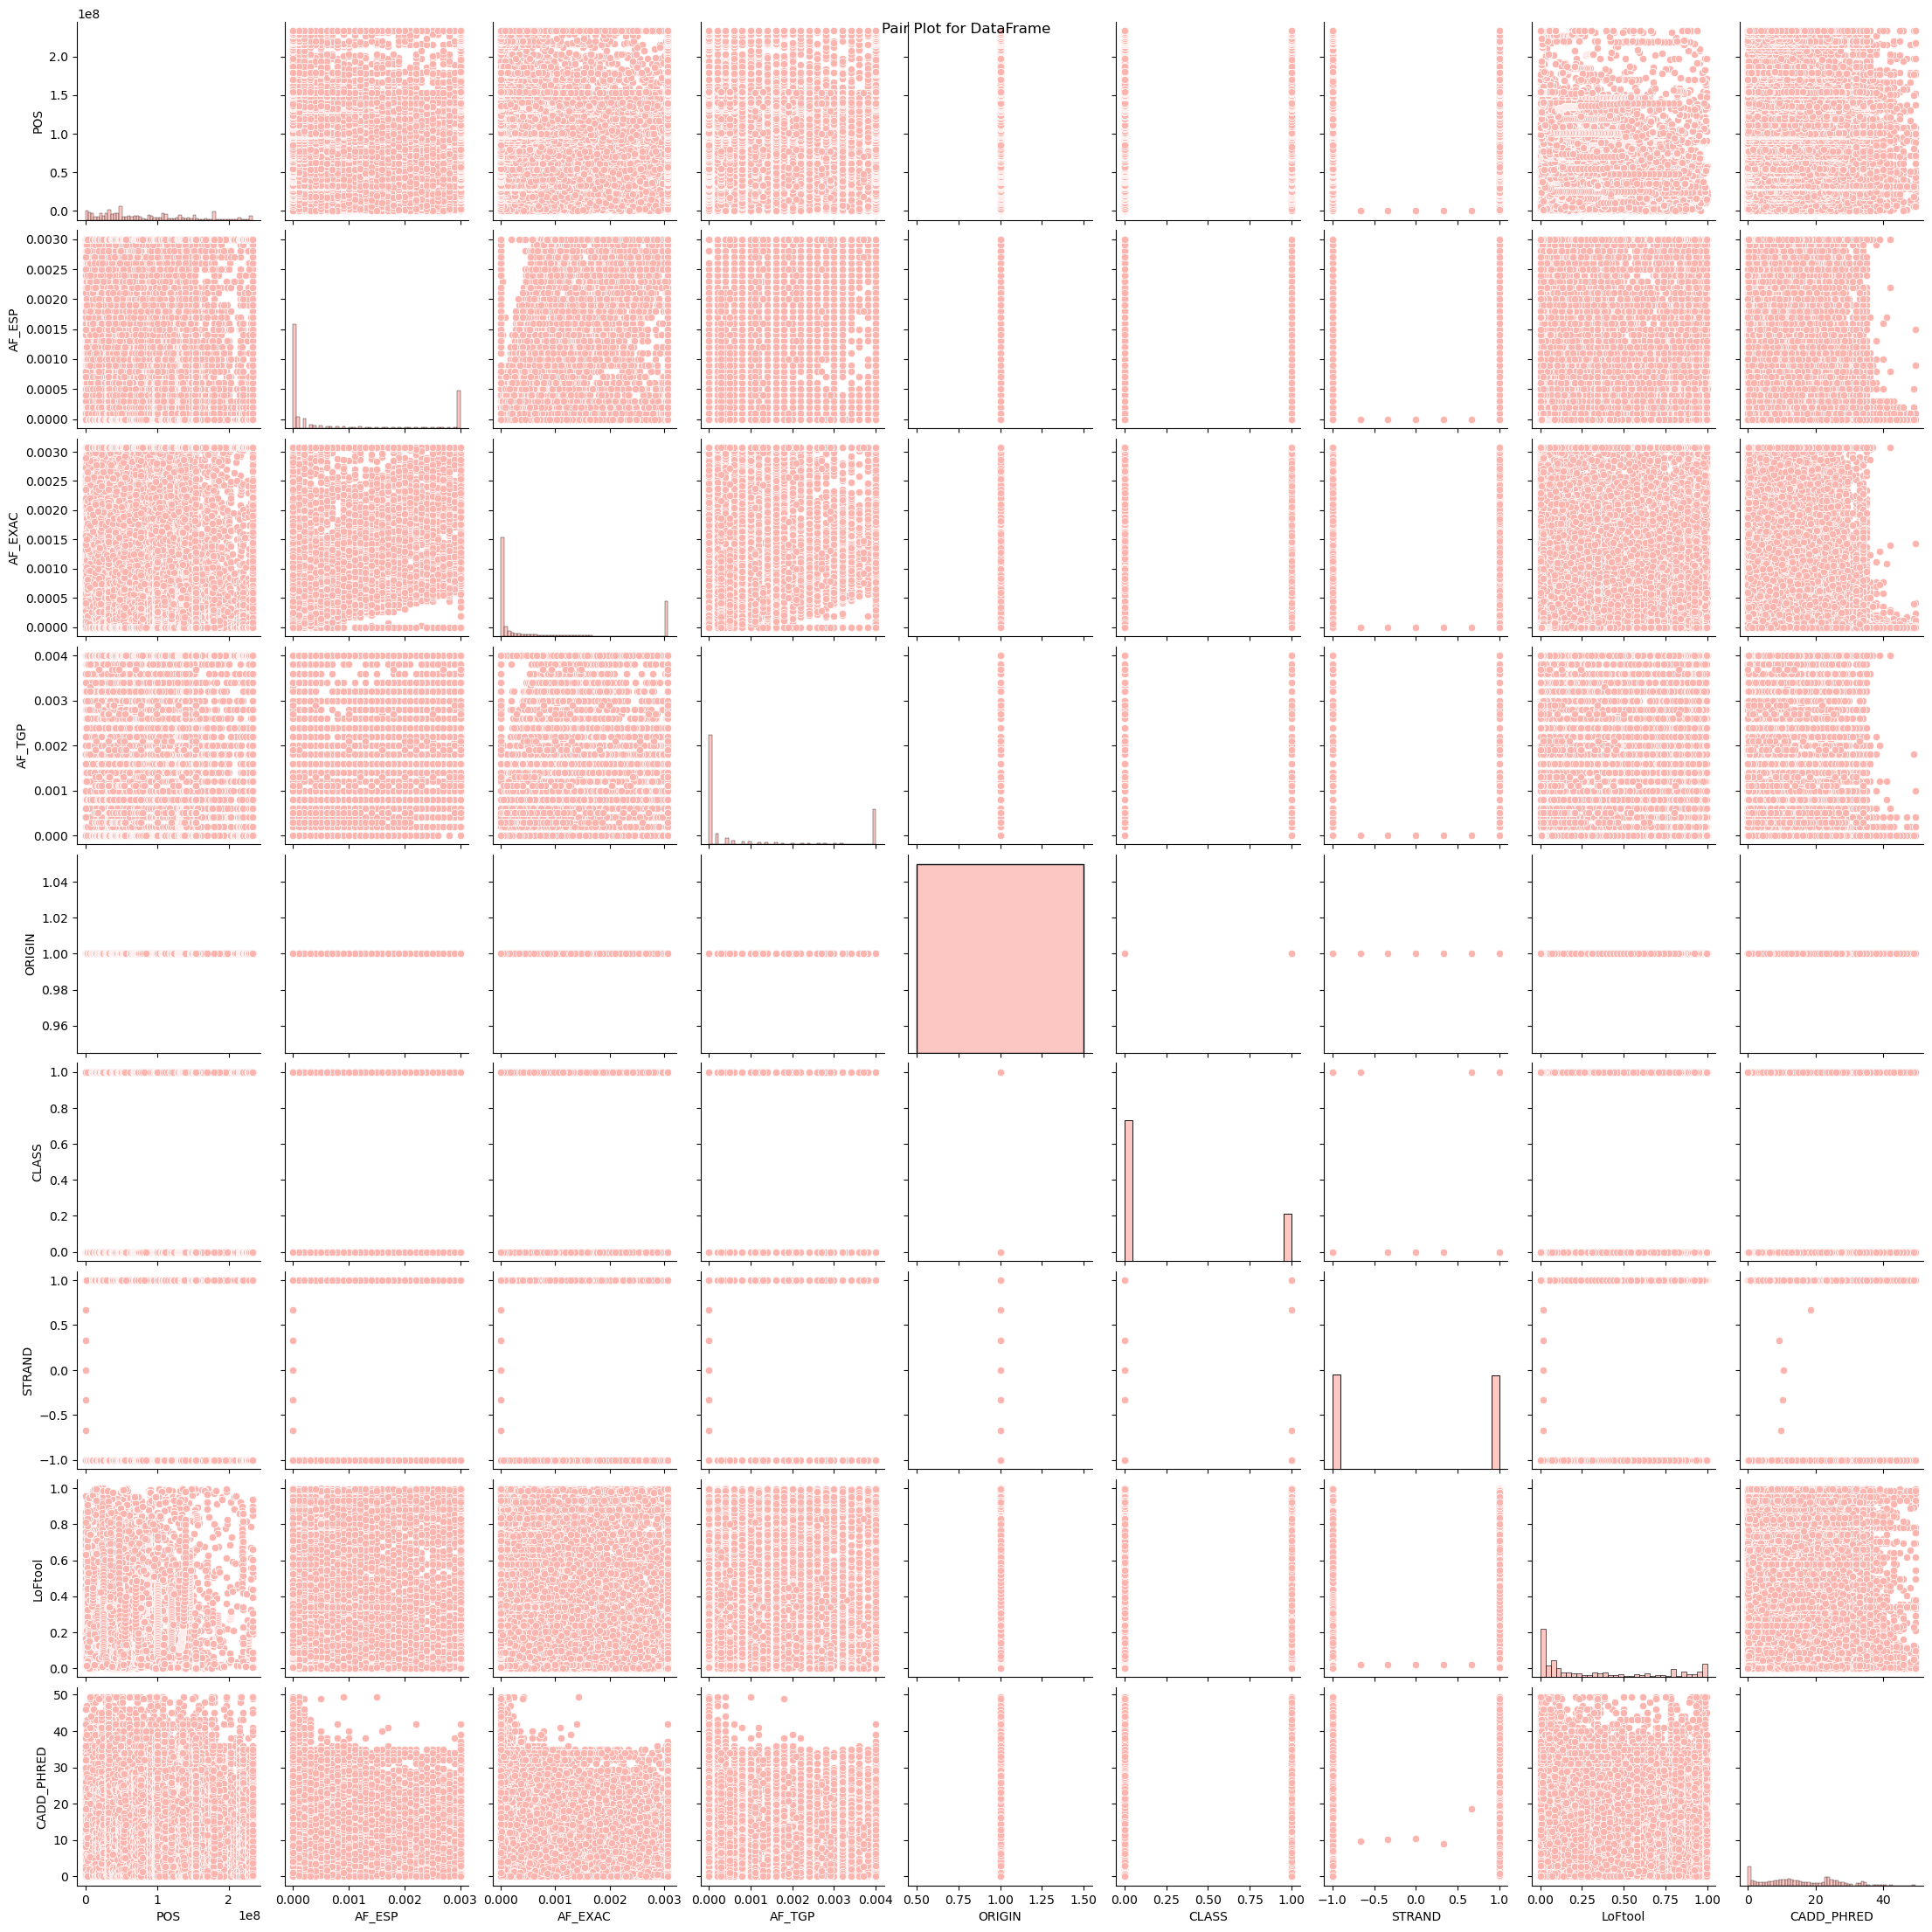

In [40]:
sns.set_palette("Pastel1")
 
# Assuming 'df' is your DataFrame
plt.figure(figsize=(10, 6))
 
# Using Seaborn to create a pair plot with the specified color palette
sns.pairplot(df_updated)
 
plt.suptitle('Pair Plot for DataFrame')
plt.show()

# model preprocessing and training 

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report,f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')
import pickle


In [42]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  float64
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  object 
 8   CLNHGVS           65188 non-null  object 
 9   CLNVC             65188 non-null  object 
 10  ORIGIN            65188 non-null  float64
 11  CLASS             65188 non-null  float64
 12  Allele            65188 non-null  object 
 13  Consequence       65188 non-null  object 
 14  IMPACT            65188 non-null  object 
 15  SYMBOL            65188 non-null  object 
 16  Feature_type      65188 non-null  object

# encoding categorical values 

In [43]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming df_updated is your DataFrame containing object-type columns
label_encoder = LabelEncoder()

# Iterate over each column in the DataFrame
for column in df_updated.columns:
    # Check if the column's dtype is 'object'
    if df_updated[column].dtype == 'object':
        # Convert all values to strings to ensure uniform data type
        df_updated[column] = df_updated[column].astype(str)
        
        # Apply label encoding to the column
        df_updated[column] = label_encoder.fit_transform(df_updated[column])

# Now df_updated contains the label encoded data


In [44]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  int32  
 1   POS               65188 non-null  float64
 2   REF               65188 non-null  int32  
 3   ALT               65188 non-null  int32  
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  int32  
 8   CLNHGVS           65188 non-null  int32  
 9   CLNVC             65188 non-null  int32  
 10  ORIGIN            65188 non-null  float64
 11  CLASS             65188 non-null  float64
 12  Allele            65188 non-null  int32  
 13  Consequence       65188 non-null  int32  
 14  IMPACT            65188 non-null  int32  
 15  SYMBOL            65188 non-null  int32  
 16  Feature_type      65188 non-null  int32 

In [45]:
df_updated

CHROM          POS  REF  ALT  AF_ESP   AF_EXAC  AF_TGP  CLNDN  CLNHGVS  \
0          0    1168180.0  437  106  0.0030  0.003075  0.0040   8960      326   
1          0    1470752.0  437    0  0.0000  0.000000  0.0000   8388      467   
2          0    1737942.0    0  213  0.0000  0.000010  0.0000   8449     1179   
3          0    2160305.0  437    0  0.0000  0.000000  0.0000   8156     1826   
4          0    2160305.0  437  335  0.0000  0.000000  0.0000   8154     1827   
...      ...          ...  ...  ...     ...       ...     ...    ...      ...   
65183     23  154158201.0  644  213  0.0030  0.003075  0.0040   3915    64090   
65184     23  154159118.0  224  335  0.0020  0.000600  0.0013   9085    64093   
65185     23  154194886.0  224  335  0.0030  0.003075  0.0040   9085    64096   
65186     23  154490187.0  644  106  0.0003  0.000340  0.0000   6683    64097   
65187     23  154508542.0  437  106  0.0019  0.002670  0.0008   9253    64098   

       CLNVC  ORIGIN  CLASS  Allele  Consequence  IMPACT  SYMBOL  \
0          6     1.0    0.0      88           17       2     200   
1          6     1.0    0.0       1           17       2    2135   
2          6     1.0    1.0     168           17       2     892   
3          6     1.0    0.0       1           17       2    1889   
4          6     1.0    0.0     296           17       2    1889   
...      ...     ...    ...     ...          ...     ...     ...   
65183      6     1.0    0.0     168           46       1     707   
65184      6     1.0    1.0     296           17       2     707   
65185      6     1.0    0.0     296           46       1     707   
65186      6     1.0    0.0      88           46       1    1711   
65187      6     1.0    0.0      88           17       2     413   

       Feature_type  BIOTYPE  cDNA_position  CDS_position  Protein_position  \
0                 1        1           8896          8316              1455   
1                 1        1           8470          8140              1381   
2                 1        1           9963          3998              6814   
3                 1        1           1616             4              4579   
4                 1        1           1616             4              4579   
...             ...      ...            ...           ...               ...   
65183             1        1           6753          6393               566   
65184             1        1           5343          4995              7289   
65185             1        1           1359           656              4928   
65186             1        1          12153          8625              1613   
65187             1        1          11788          8468              1545   

       Amino_acids  Codons  STRAND   LoFtool  CADD_PHRED  
0              257    1653     1.0  0.343752       1.053  
1              756    1143    -1.0  0.343752      31.000  
2              480     813    -1.0  0.343752      28.100  
3              377     523     1.0  0.343752      22.500  
4              362     525     1.0  0.343752      24.700  
...            ...     ...     ...       ...         ...  
65183          968    2083    -1.0  0.001580       0.105  
65184         1154     535    -1.0  0.001580       0.002  
65185           78    1753    -1.0  0.001580      12.850  
65186         1070     885    -1.0  0.070790       0.130  
65187          750     333    -1.0  0.140000       0.046  

[65188 rows x 26 columns]

# creatinng new features 

In [46]:
#creation of new compostions 
# Calculate mean of 'AF_ESP', 'AF_EXAC', and 'AF_TGP'
df_updated['Allele_Freq_Mean'] = df_updated[['AF_ESP', 'AF_EXAC', 'AF_TGP']].mean(axis=1)

# Calculate mean of 'LoFtool' and 'CADD_PHRED'
df_updated['Pathogenicity_Score_Mean'] = df_updated[['LoFtool', 'CADD_PHRED']].mean(axis=1)



In [47]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CHROM                     65188 non-null  int32  
 1   POS                       65188 non-null  float64
 2   REF                       65188 non-null  int32  
 3   ALT                       65188 non-null  int32  
 4   AF_ESP                    65188 non-null  float64
 5   AF_EXAC                   65188 non-null  float64
 6   AF_TGP                    65188 non-null  float64
 7   CLNDN                     65188 non-null  int32  
 8   CLNHGVS                   65188 non-null  int32  
 9   CLNVC                     65188 non-null  int32  
 10  ORIGIN                    65188 non-null  float64
 11  CLASS                     65188 non-null  float64
 12  Allele                    65188 non-null  int32  
 13  Consequence               65188 non-null  int32  
 14  IMPACT

# scalling data using StandardScaler

In [48]:
scaler = StandardScaler()

# Iterate over columns in your DataFrame
for column in df_updated.columns:
    # Check if column data type is int32 or float64
    if df_updated[column].dtype == 'int32' or df_updated[column].dtype == 'float64':
        # Fit and transform the data using StandardScaler
        df_updated[column] = scaler.fit_transform(df_updated[[column]])

## Define model variables and spliting into test and train 

In [49]:
X=df_updated.drop(['CLASS'] , axis=1)
y=df_updated['CLASS']

In [50]:
#spliting model variables
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [51]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(45631, 27)
(19557, 27)
(45631,)
(19557,)


In [53]:
print(np.unique(y_train))

[-0.58058594  1.72239789]


## inference :
As the target data for classification project have to be discrete values so we applied discretization 

In [77]:
num_bins = 1
bin_edges = np.linspace(np.min(y_train), np.max(y_train), num_bins + 1)

# Discretize the target variable into bins
y_train_discrete = np.digitize(y_train, bin_edges)

# Print the unique values in the discretized target variable
print(np.unique(y_train_discrete))
y_test_discrete = np.digitize(y_test, bin_edges)

# Print the unique values in the discretized test target variable
print(np.unique(y_test_discrete))

[1 2]
[1 2]


## importing training models 

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

## handaling unbalanced data 

In [55]:
smote_factor=SMOTE(random_state=11)
x_smote, y_smote = smote_factor.fit_resample(X_train, y_train_discrete)
print("Shape before the Oversampling : ",X_train.shape)
print("Shape after the Oversampling : ",x_smote.shape)
x_smote_test, y_smote_test = smote_factor.fit_resample(X_test,y_test_discrete)
print("Shape before the Oversampling : ",X_test.shape)
print("Shape after the Oversampling : ",x_smote_test.shape)

Shape before the Oversampling :  (45631, 27)
Shape after the Oversampling :  (68278, 27)
Shape before the Oversampling :  (19557, 27)
Shape after the Oversampling :  (29230, 27)


## traing models and evalution 

In [56]:
models = {
    LogisticRegression(max_iter=500):'Logistic Regression',
    SVC():"Support Vector Machine",
    RandomForestClassifier():'Random Forest',
    KNeighborsClassifier(n_neighbors=5):'KNN',
    DecisionTreeClassifier():'Decision Tree',
    GradientBoostingClassifier():'GradientBoosting',
    AdaBoostClassifier():'AdaBoost'
}
for m in models.keys():
    m.fit(x_smote,y_smote)
for model,name in models.items():
      print(f"Accuracy Score for {name} is : ",model.score(x_smote_test, y_smote_test)*100,"%")

Accuracy Score for Logistic Regression is :  56.63701676359905 %
Accuracy Score for Support Vector Machine is :  70.42422169004448 %
Accuracy Score for Random Forest is :  80.24974341430038 %
Accuracy Score for KNN is :  61.12897707834417 %
Accuracy Score for Decision Tree is :  73.7632569278139 %
Accuracy Score for GradientBoosting is :  79.03523776941499 %
Accuracy Score for AdaBoost is :  74.97434143003763 %


In [58]:
for model,name in models.items():
    y_pred = model.predict(x_smote_test)
    print(f"Classification  Report of  performance  for {name}")  
    print("----------------------------------------------------------")
    print(classification_report(y_smote_test,y_pred))
    print("----------------------------------------------------------")

Classification  Report of  performance  for Logistic Regression
----------------------------------------------------------
              precision    recall  f1-score   support

           1       0.59      0.44      0.51     14615
           2       0.55      0.69      0.61     14615

    accuracy                           0.57     29230
   macro avg       0.57      0.57      0.56     29230
weighted avg       0.57      0.57      0.56     29230

----------------------------------------------------------
Classification  Report of  performance  for Support Vector Machine
----------------------------------------------------------
              precision    recall  f1-score   support

           1       0.71      0.69      0.70     14615
           2       0.70      0.72      0.71     14615

    accuracy                           0.70     29230
   macro avg       0.70      0.70      0.70     29230
weighted avg       0.70      0.70      0.70     29230

--------------------------------------

## now we have 2 models with the highest accuracy and classification report values .additional test is needed to choose the best one (random forrst and graidient boost )

In [59]:
rf = RandomForestClassifier()
rf.fit(x_smote,y_smote)
rf.score(x_smote_test, y_smote_test )


0.8037974683544303

In [60]:
clf=GradientBoostingClassifier()
clf.fit(x_smote,y_smote)
clf.score(x_smote_test, y_smote_test )

0.7903523776941499

In [63]:
fpr, tpr, thresholds = roc_curve(y_smote_test, y_probs_postive, pos_label=2)



In [61]:
from sklearn.metrics import roc_curve
y_probs = rf.predict_proba(x_smote_test)
y_probs 


array([[0.55, 0.45],
       [0.9 , 0.1 ],
       [0.53, 0.47],
       ...,
       [0.  , 1.  ],
       [0.35, 0.65],
       [0.09, 0.91]])

In [62]:
y_probs_postive = y_probs[ :, 1]
y_probs_postive[:10]

array([0.45, 0.1 , 0.47, 0.17, 0.76, 0.66, 0.68, 0.18, 0.39, 0.71])

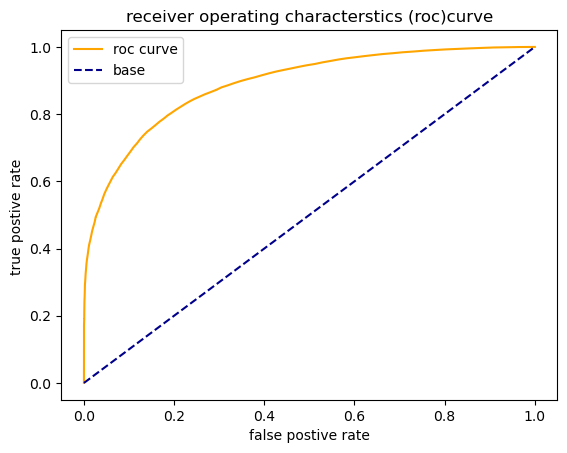

In [64]:
def plot_roc_AUC(fpr,tpr):
    plt.plot(fpr,tpr, color='orange',label='roc curve') 
    #plot line with no predictive power (baseline )
    plt.plot([0,1],[0,1],color='darkblue',linestyle='--',label='base')
    #customization of the plot
    plt.xlabel('false postive rate')
    plt.ylabel('true postive rate ')
    plt.title('receiver operating characterstics (roc)curve')
    plt.legend()
    plt.show()
plot_roc_AUC(fpr,tpr)

In [65]:
from sklearn.metrics import roc_auc_score
roc_auc_score( y_smote_test,y_probs_postive)

0.8899886785107882

In [66]:
from sklearn.metrics import roc_curve
y_probs_1 = clf.predict_proba(x_smote_test)
y_probs_1

array([[0.58862   , 0.41138   ],
       [0.78670661, 0.21329339],
       [0.30254206, 0.69745794],
       ...,
       [0.27253989, 0.72746011],
       [0.22982773, 0.77017227],
       [0.08053208, 0.91946792]])

In [67]:
y_probs_postive_1 = y_probs[ :, 1]
y_probs_postive_1[:10]

array([0.45, 0.1 , 0.47, 0.17, 0.76, 0.66, 0.68, 0.18, 0.39, 0.71])

In [68]:
fpr, tpr, thresholds = roc_curve(y_smote_test, y_probs_postive_1, pos_label=2)

In [ ]:
# def plot_roc_AUC(fpr,tpr):
    plt.plot(fpr,tpr, color='orange',label='roc curve') 
    #plot line with no predictive power (baseline )
    plt.plot([0,1],[0,1],color='darkblue',linestyle='--',label='base')
    #customization of the plot
    plt.xlabel('false postive rate')
    plt.ylabel('true postive rate ')
    plt.title('receiver operating characterstics (roc)curve')
    plt.legend()
    plt.show()
plot_roc_AUC(fpr,tpr)

In [70]:
from sklearn.metrics import roc_auc_score
roc_auc_score( y_smote_test,y_probs_postive)

0.8899886785107882

## inference 
AUC /ROC TEST from to the AUC  score we found that they have the same auc_score so we choosed the random forest it have higher accuracy score ;80and better classification report values%

# features importance descovery 

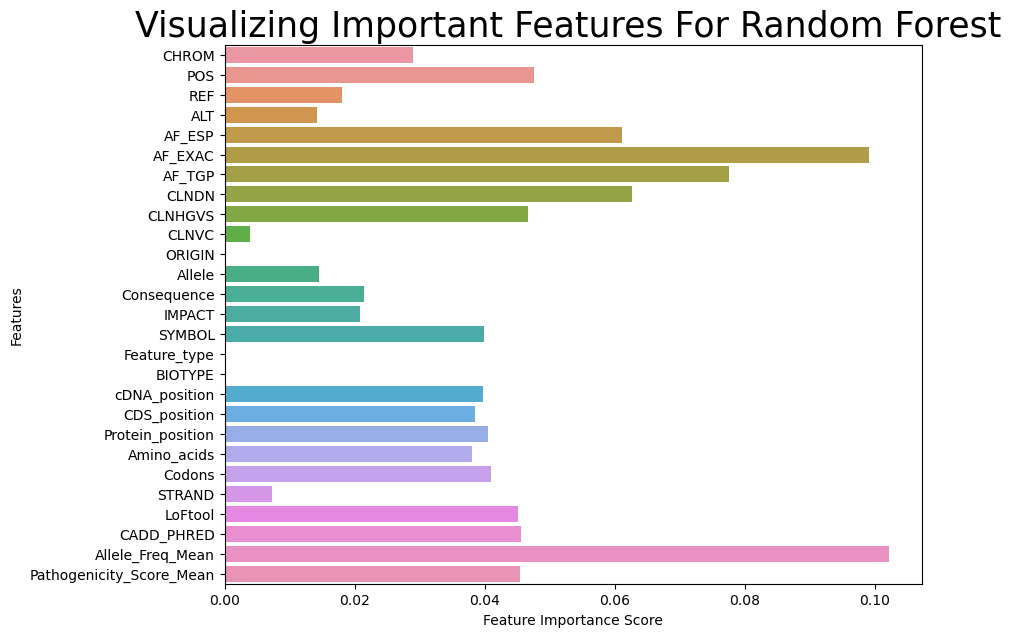

In [71]:
#we will choose random forest 
plt.figure(figsize=(9,7))
feature_imp1 = rf.feature_importances_
sns.barplot(x=feature_imp1, y=X.columns)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features For Random Forest ",{'fontsize':25})
plt.show();

## retrain model based on top twenty important features for our model

In [109]:
data = pd.DataFrame(df_updated)
drop_cols = ['ORIGIN', 'Feature_type', 'BIOTYPE', 'CLNVC', 'STRAND', 'Allele', 'IMPACT']
supsted_data= data.drop(columns=drop_cols)

# Print the new DataFrame
supsted_data
#training moodle based on new df
X=supsted_data.drop(['CLASS'] , axis=1)
y=supsted_data['CLASS']
#spliting model variables
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(np.unique(y_train))
num_bins = 1
bin_edges = np.linspace(np.min(y_train), np.max(y_train), num_bins + 1)

# Discretize the target variable into bins
y_train_discrete = np.digitize(y_train, bin_edges)

# Print the unique values in the discretized target variable
print(np.unique(y_train_discrete))
y_test_discrete = np.digitize(y_test, bin_edges)

# Print the unique values in the discretized test target variable
print(np.unique(y_test_discrete))
smote_factor=SMOTE(random_state=11)
x_smote, y_smote = smote_factor.fit_resample(X_train, y_train_discrete)
print("Shape before the Oversampling : ",X_train.shape)
print("Shape after the Oversampling : ",x_smote.shape)
x_smote_test, y_smote_test = smote_factor.fit_resample(X_test,y_test_discrete)
print("Shape before the Oversampling : ",X_test.shape)
print("Shape after the Oversampling : ",x_smote_test.shape)


(45631, 20)
(19557, 20)
(45631,)
(19557,)
[-0.58058594  1.72239789]
[1 2]
[1 2]
Shape before the Oversampling :  (45631, 20)
Shape after the Oversampling :  (68278, 20)
Shape before the Oversampling :  (19557, 20)
Shape after the Oversampling :  (29230, 20)


In [111]:
rf = RandomForestClassifier()
rf.fit(x_smote,y_smote)
rf.score(x_smote_test, y_smote_test )


0.8006158056790968

# inference :
    It give us model accuracy =80,0% but the original accuracy for model was 80,3% so we choose to complete with the original data set 
Note ;working with subset will not effect the process badly as the accuracy difference is small


# hyper paramter tunning 

In [97]:
from sklearn.model_selection import GridSearchCV ,RandomizedSearchCV

In [98]:
#Define the parameter grid
param_grid = { 
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9],
}

In [138]:
random_search = RandomizedSearchCV(RandomForestClassifier(), 
                                   param_grid) 
random_search.fit(x_smote,y_smote) 
print(random_search.best_estimator_) 

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=9,
                       n_estimators=50)


In [100]:
model_random = RandomForestClassifier(max_depth=6, 
                                      max_features=None, 
                                      max_leaf_nodes=9, 
                                      n_estimators=25)
model_random.fit(x_smote,y_smote) 
y_pred = model_random .predict(x_smote_test) 
print(classification_report(y_pred, y_smote_test)) 
print(f"Accuracy Score for randomforest model after paramters tunning is : ",model_random.score(x_smote_test, y_smote_test)*100,"%")

              precision    recall  f1-score   support

           1       0.65      0.66      0.66     14411
           2       0.66      0.66      0.66     14819

    accuracy                           0.66     29230
   macro avg       0.66      0.66      0.66     29230
weighted avg       0.66      0.66      0.66     29230

Accuracy Score for randomforest model after paramters tunning is :  65.7475196715703 %


In [99]:
 ##Create a GridSearchCV object with parallel processing
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=2, n_jobs=4)

# Perform the grid search
grid_search.fit(x_smote,y_smote)

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 9, 'n_estimators': 25}
Best Score: 0.6526992597521525


# inference  
So decision was taken to set our model with the default parameters states 

# model deployment 


In [73]:
import pickle
filename ='machine_model_1.sav'
pickle.dump(rf, open(filename, 'wb'))

# deployment steps are going to be completed on visual studio using streamlit  using the previous file   

In [112]:
#clf=GradientBoostingClassifier()
#clf.fit(x_smote,y_smote)
#clf.score(x_smote_test, y_smote_test )

0.7902497434143004

In [78]:
available_features = list(set(df_updated.columns) & set(['Allele_Freq_Mean','CLASS','CHROM,']))
#if available_features:
    #data = df_updated[available_features]
    #print("Selected features:", available_features)
#else:
    #print("No matching features found in the DataFrame")

Selected features: ['Allele_Freq_Mean', 'CLASS']


In [122]:
#data.info()

In [81]:
#scaler = StandardScaler()

# Iterate over columns in your DataFrame
#for column in data.columns:
    # Check if column data type is int32 or float64
    #if data[column].dtype == 'int32' or data[column].dtype == 'float64':
        # Fit and transform the data using StandardScaler
        #data[column] = scaler.fit_transform(data[[column]])

In [82]:
#x=data.drop(['CLASS'] , axis=1)
#y=data['CLASS']

In [83]:
#spliting model variables
#X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [84]:
print(X_train.shape)
#print(X_test.shape)
#print(y_train.shape)
#print(y_test.shape)

(45631, 1)
(19557, 1)
(45631,)
(19557,)


In [85]:
n#um_bins = 1
#bin_edges = np.linspace(np.min(y_train), np.max(y_train), num_bins + 1)
#
 #Discretize the target variable into bins
#y_train_discrete = np.digitize(y_train, bin_edges)

#Print the unique values in the discretized target variable
#print(np.unique(y_train_discrete))
#y_test_discrete = np.digitize(y_test, bin_edges)

# Print the unique values in the discretized test target variable
#print(np.unique(y_test_discrete))

[1 2]
[1 2]


In [86]:
smote_factor=SMOTE(random_state=11)
#x_smote, y_smote = smote_factor.fit_resample(X_train, y_train_discrete)
#print("Shape before the Oversampling : ",X_train.shape)
#print("Shape after the Oversampling : ",x_smote.shape)
#x_smote_test, y_smote_test = smote_factor.fit_resample(X_test,y_test_discrete)
#print("Shape before the Oversampling : ",X_test.shape)
#print("Shape after the Oversampling : ",x_smote_test.shape)

Shape before the Oversampling :  (45631, 1)
Shape after the Oversampling :  (68278, 1)
Shape before the Oversampling :  (19557, 1)
Shape after the Oversampling :  (29230, 1)


In [87]:
rf = RandomForestClassifier()
#rf.fit(x_smote,y_smote)
#rf.score(x_smote_test, y_smote_test )


0.6483407458091003